# Classifying Melanoma: CNN & Logistic Regression

by Tim Chen (chentim@berkeley.edu)

## CNN Architecture & Workflow
![alt text](https://lh3.googleusercontent.com/ygPpZGXERqiROjw5MdiujUKD38J45CCaHnSxWdEc8qRwEo2r2I-49v5JlprnRGlVdHkkvcX9prqy-gZBzLQk26GiBbIfv-6EaJcrOMvNAE5GigVRmcGZyu9pXuTkEBK6tedLdBnzh3h_4_MEp8nKW4Sj7k-MP4OJF4IanPZcdGiqzI4W9nxRDzCSFy_hkOIkq9VBuKsQkZJ9ntfhxVUaoOLP7O05TBBTJ7KEVx6OBYFCMyJcK8ZXE5qHLIiDFWwLNAPHxIZC0Xfw9HTH_-V-4qA3S-RlJJPh7lkt9RDD27LAoloRcgR5pXf4lidS-ArnhEnen3T0vjLDFS4qSkLn7knObzJbKHxql5YuILMxf6flLWAPDojFFvrT25VAIf_PYe6OfnJ-Abu5hFeQa8jBGmXHAoKS66MMPidDybLBlHlRHEwBM2w0S3PGF_YjGVPJeEf0uNSffGZz4qz6x7CcFVphOBqOhdnl7PBtE0jqyF6voC7sbIa04BtON0i700aizzrpojM6EJurIi86fCo0q-wIFhgFmZ6E-dU6Y1_sX-TZEJnjB9Ni-ro4BcDXyqDstdHe0xrpKiK_pI5OPXvXtd1vqZh_C7-QgmZPMwKh1_6h-fIq4cbuO7ngyLUX5D15WwzAuugqZTRE7s1g4JgfJyFMgB0XHoti1ENL8OUknf_EdymUA82x_LncsiXLZWw=w1960-h971-no?authuser=0)

## Environment Setup

### Installs & Imports

In [ ]:
# install libraries not on colab
%pip install -U --pre efficientnet

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow.keras as keras
import efficientnet.tfkeras as efn

from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from tensorflow.keras import backend as K
from tensorflow.train import Feature, Features, Example
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import applications
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np
import pandas as pd

import re
import math
import os
import sys
import warnings
import logging
import random

from datetime import datetime
from IPython.display import display 
from io import BytesIO
from PIL import Image
from skimage import io
from typing import List, Tuple

# local vs. colab
IS_LOCAL = False

if IS_LOCAL:
    # jupyter offline
    PATH_KAGGLE_MEL = './../kaggle_symlink_offline/melanoma/'
    REPO_ROOT = './../../'
    REPO_TEMP = REPO_ROOT + 'temp/'
    TFREC_DIR = REPO_ROOT + 'tim/kaggle_symlink_offline/melanoma/tfrecords/triple_stra_{}/'
else:
    # http://tiny.cc/8jjjsz
    # loading from Kaggle to save $$$ (vs. loading from my own GCS)
    KAGGLE_TFREC_GCS ={
        128: 'gs://kds-659708bf9143f303ebfd1c862eb9e842090662d9004190208d007cc9',
        192: 'gs://kds-f53b5775dce9868747163621afd1adc2815412f220130261292837a3',
        256: 'gs://kds-f64cfd42bcb769b2eeeecd53d5a52df83d43c19c1184989ed762e30f',
        384: 'gs://kds-e73569ee9d44308363027e79908294593e80b1e12e18e57ef065397c',
        512: 'gs://kds-4f5e437bc05e29f3e95419fa289ea3a6b01ac2fefcb772ca07cc3b5f',
        768: 'gs://kds-49b793da52a884d00e33c11613f3f24261d8e53e1b8c16de8c868509'}

    # colab online
    PATH_KAGGLE_MEL = '/content/gdrive/My Drive/Kaggle/melanoma/'
    REPO_ROOT = '/content/gdrive/My Drive/melanoma/'
    REPO_TEMP = REPO_ROOT + 'temp/'
    
    # mount google drive only on colab
    from google.colab import drive
    drive.mount('/content/gdrive')

warnings.filterwarnings("ignore") # suppress warning messages
plt.style.use('ggplot')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Model Configurations

In [ ]:
if IS_LOCAL: # configr optimize for efficiency due to limited computing power
    # option: TPU, GPU (default to CPU if the specified processor is not found)
    PROCESSOR = "GPU" 

    FOLDS = 2 # option: 3, 5, 15 
    TFREC_SPLITS = 2 # count of tfrec files, hardcoded just for convenience

    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    BATCH_SIZES = [32] * FOLDS 
    EPOCHS = [10] * FOLDS

    # 0: BinaryCrossentropy
    # 1: FocalLoss
    LOSS_FUNCTIONS = [0, 0] 
    LOSS_FUNC_NAMES = ['Binary Crossentropy', 'Focal Loss']
    FL_GAMMA = 2.0
    FL_ALPHA = 0.75
    LEARNING_RATE = 0.001

    EFF_NETS = [0, 4]
    # 128, 192, 256, 384, 512, 768, 1024
    IMG_SIZES = [128, 128]

    TFREC_TRAIN_SETS = [None] * FOLDS
    for i, dim in enumerate(IMG_SIZES):
        TFREC_TRAIN_SETS[i] = tf.io.gfile.glob(TFREC_DIR.format(dim) + 'train*.tfrec')

    # Images used for validation should be subject to the same random augmentation
    # mechanism if input images are randomly augmented. TTA specifies the number of 
    # times each validation image will be randomly augmented and predicted. A final
    # predicted probability is then calculated by averaging.
    TTA_STEPS = 1 # TEST TIME AUGMENTATION STEPS
    RANDOM_AUG = False

    # set true to load the weights from "epoch with the best performance" at the 
    # end of training
    BEST_MODEL = True
    # all models predicts probabilities instead of labels; this threshold is 
    # used only for reporting
    SIGMOID_THD = 0.2

else: # configr optimize for performance
    PROCESSOR = "TPU" 

    FOLDS = 5
    TFREC_SPLITS = 15
    
    # dim 512 and bs 128 is the limit of TPU on Colab
    BATCH_SIZES = [64] * FOLDS 
    EPOCHS = [10] * FOLDS

    # 0: BinaryCrossentropy
    # 1: FocalLoss
    LOSS_FUNCTIONS = [0, 1, 0, 1, 0]
    LOSS_FUNC_NAMES = ['Binary Crossentropy', 'Focal Loss']
    FL_GAMMA = 2.0
    FL_ALPHA = 0.75
    LEARNING_RATE = 0.001

    EFF_NETS = [7, 7, 4, 4, 0]
    IMG_SIZES = [256, 256, 256, 256, 256]

    TFREC_TRAIN_SETS = [None] * FOLDS
    for i, dim in enumerate(IMG_SIZES):
        TFREC_TRAIN_SETS[i] = tf.io.gfile.glob(KAGGLE_TFREC_GCS[dim] + '/train*.tfrec')

    TTA_STEPS = 10
    RANDOM_AUG = True

    BEST_MODEL = True
    SIGMOID_THD = 0.2


SEED = 207 # used for creating k-fold

### Initializing TPU

In [ ]:
if PROCESSOR == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU: ', tpu.master())
    except ValueError:
        print("Error: Unable to connect to TPU...")
        tpu = None

    if tpu:
        try:
            print("Initializing TPU...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized!")
        except _:
            print("Error: Failed to initialize TPU...")
    else:
        PROCESSOR = "GPU"

if PROCESSOR != "TPU":
    print("Using default strategy for CPU/GPU...")
    strategy = tf.distribute.get_strategy()

if PROCESSOR == "GPU":
    print("# of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
            
# https://tinyurl.com/yao4obsb
# A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
# Therefore, for efficient utilization of Cloud TPU, a program should make use of 
# each of the eight cores.
REPLICAS = strategy.num_replicas_in_sync
print(f'# of replicatas in sync: {REPLICAS}')

connecting to TPU...
Running on TPU:  grpc://10.97.28.250:8470
Initializing TPU...
INFO:tensorflow:Initializing the TPU system: grpc://10.97.28.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.97.28.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized!
# of replicatas in sync: 8


### Classes & Functions

In [ ]:
class TFRECParser:
    """Class to parse the TFRecord files that come with the original dataset.
    """
    __TFREC_DESCRIPTOR = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    } 

    def __init__(self) -> None:
        self.__dataset = None # tf.data.TFRecordDataset

    @tf.autograph.experimental.do_not_convert
    def load(self, path_tfrec: str = 'tfrecords/train*.tfrec') -> None:
        def parser(serialized_example: Example) -> Example:
            example = tf.io.parse_single_example(serialized_example,
                                                 features=TFRECParser.__TFREC_DESCRIPTOR)
            return example
        self.__dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path_tfrec))
        self.__dataset = self.__dataset.map(parser)

    def get_dataset(self) -> tf.data.Dataset:
        return self.__dataset

    def get_image_arr(self, image_name: str) -> np.ndarray:
        record_dataset = self.__dataset.filter(lambda example: tf.equal(example["image_name"], image_name))
        example = next(iter(record_dataset))
        arr = tf.image.decode_jpeg(example['image'], channels=3).numpy()
        return arr

    def get_image(self, image_name: str) -> Image:
        return Image.fromarray(self.get_image_arr(image_name))

    def plot_image(self, image_name: str, 
                   figsize: list = [5, 5], 
                   ax: plt.axes = None,
                   show_info: bool = False) -> Image:
        img_arr = self.get_image_arr(image_name)
        img = Image.fromarray(img_arr)

        # prep title
        if show_info:
            title = "{}, {}x{}, {:.2f}MB".format(image_name,
                                                img.size[0],
                                                img.size[1],
                                                sys.getsizeof(img_arr)/1024/1024)
        else:
            title = image_name

         # render plot
        if ax is None:
            plt.figure(figsize=figsize)
            io.imshow(img_arr)
            plt.title(title)
            plt.show()
        else:
            ax.imshow(img_arr)
            ax.set_title(title)
    
    def plot_images(self, img_names: list, title: str = None) -> None:
        if len(img_names) == 1:
            self.plot_image(img_names[0])
            return

        PLOT_COL_COUNT = 7

        img_names = img_names.copy()

        n = len(img_names)
        row_count = n // PLOT_COL_COUNT
        if n % PLOT_COL_COUNT != 0 or row_count == 0:
            row_count += 1

        if row_count > 1:
            fig, axes = plt.subplots(row_count, 
                                     PLOT_COL_COUNT,
                                     figsize=(PLOT_COL_COUNT*3, row_count*3))
            if title is not None:
                fig.suptitle(title, fontsize=16)
                
            for row in axes:
                for ax in row:
                    # style
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    # render
                    if len(img_names) > 0:
                        self.plot_image(img_names.pop(), ax=ax)
        else:
             fig, axes = plt.subplots(1, n, figsize=(n*4, 4))
             if title is not None:
                 fig.suptitle(title, fontsize=16)

             for ax in axes:
                 # style
                 ax.get_xaxis().set_visible(False)
                 ax.get_yaxis().set_visible(False)

                 # render
                 self.plot_image(img_names.pop(), ax=ax)

def read_labeled_tfrecord(example: Example) -> Tuple['tf.string', 'tf.int64']:
    """Extract image & label from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example: Example, 
                            return_img_name: bool) -> Tuple['tf.string', 'tf.int64']:
    """Label is unavailable, extract image & image name from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    if return_img_name:
        return example['image'], example['image_name']
    else:
        return example['image'], 0

def aug_image(img, augment=True, dim=256):
    """Apply random transformation.
    """
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_flip_up_down(img)
        img = tf.clip_by_value(img, 0.0, 1.0)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_examples(file_names: List[str]):
    """Note that the name of each tfrecord file is sufixed with the number of 
    images included.
    """
    n = [int(re.compile(r"-([0-9]*)\.").search(f).group(1)) 
         for f in file_names]
    return np.sum(n)
                  
def get_dataset(tfrec_files: List[str], 
                dim: int,
                batch_size: int = 64,
                augment: bool = False, 
                shuffle: bool = False, 
                repeat: bool = False, 
                labeled: bool = True, 
                return_img_names: bool = True,
                drop_remainder: bool = False,
                replicas: int = strategy.num_replicas_in_sync) -> Tuple[tf.data.TFRecordDataset, int]:
    """Return a TFRecordDataset by loading tfrecord files.
    Args:
        tfrec_files (List[str]): List of paths to the tfrecord files.
    Returns:
        [0](TFRecordDataset): Two possible column combinations... 
            - 'image' & 'target' for training dataset
            - 'image' & 'image_name' for test dataset
        [1](int): Number of steps to complete an epoch.
    """
    
    AUTO = tf.data.experimental.AUTOTUNE
    ds = tf.data.TFRecordDataset(tfrec_files, 
                                 num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(buffer_size=1024) # 1024 to optimize TPU performance
        opt = tf.data.Options()
        opt.experimental_deterministic = False # ensure a true random shuffle
        ds = ds.with_options(opt)
    
    if labeled: 
        # extract image & label
        # ds inlcudes just one column of examples
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        # extract image & image name
        # ds inlcudes just one column of examples
        map_ = lambda example: read_unlabeled_tfrecord(example, return_img_names)
        ds = ds.map(map_, num_parallel_calls=AUTO)      
    
    # transform image
    # ds has two columns: "image (intf.string)" and "label or image name"
    map_ = lambda img, _: (aug_image(img, augment=augment, dim=dim), _)
    ds = ds.map(map_, num_parallel_calls=AUTO)
    
    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    if PROCESSOR == 'TPU':
        if batch_size < 64:
            # better
            print('Warning: Batch size {} is smaller than 64...'.format(batch_size))
        if batch_size % 8 > 0:
            # min requirement
            print('Error: Batch size {} is not a multiple of 8...'.format(batch_size))
    ds = ds.batch(batch_size, drop_remainder=drop_remainder) 
    
    num_images = count_examples(tfrec_files)
    steps = num_images // batch_size
    if num_images % batch_size > 0:
        # require one more step to loop through the entire dataset
        steps += 1
    
    # From tf doc (https://tinyurl.com/yavczqkr):
    # Most dataset input pipelines should end with a call to prefetch. This allows 
    # later elements to be prepared while the current element is being processed. This 
    # often improves latency and throughput, at the cost of using additional memory to 
    # store prefetched elements.
    ds = ds.prefetch(AUTO)
    
    return ds, steps

def focal_loss(gamma: float = 2., alpha: float = .25) -> callable:
    """Soruces:
            https://tinyurl.com/y4e66a44
            https://tinyurl.com/yyudyorg
    """
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def build_efns(dim: int, 
               ef: int, 
               loss: int = 0,
               sig_thd: float = SIGMOID_THD,
               fl_gamma: float = FL_GAMMA,
               fl_alpha: float = FL_ALPHA,
               lr: float = LEARNING_RATE) -> Sequential:

    EFNS = [efn.EfficientNetB0, 
            efn.EfficientNetB1, 
            efn.EfficientNetB2, 
            efn.EfficientNetB3, 
            efn.EfficientNetB4, 
            efn.EfficientNetB5, 
            efn.EfficientNetB6,
            efn.EfficientNetB7]
    LOSS_FS = [keras.losses.BinaryCrossentropy(label_smoothing=0.05),
               focal_loss(fl_gamma, fl_alpha)]
    
    m = Sequential()
    base = EFNS[ef](weights="imagenet", 
                    include_top=False, 
                    input_shape=(dim, dim, 3))
    m.add(base)
    m.add(GlobalAveragePooling2D())
    m.add(Dense(1, activation="sigmoid"))
    
    # compile model
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
              loss=LOSS_FS[loss], 
              metrics=[AUC(),
                       BinaryAccuracy(threshold=sig_thd),
                       Recall(thresholds=sig_thd)])

    return m

## Image Generator Testing

### Testing TFRecord

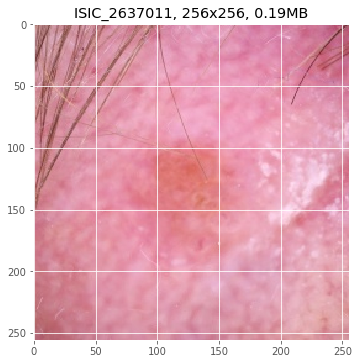

In [ ]:
# testing: render a smaple image
parser = TFRECParser()
parser.load(TFREC_TRAIN_SETS[0][0])
parser.plot_image('ISIC_2637011', show_info=True)

### Testing Random Transformation

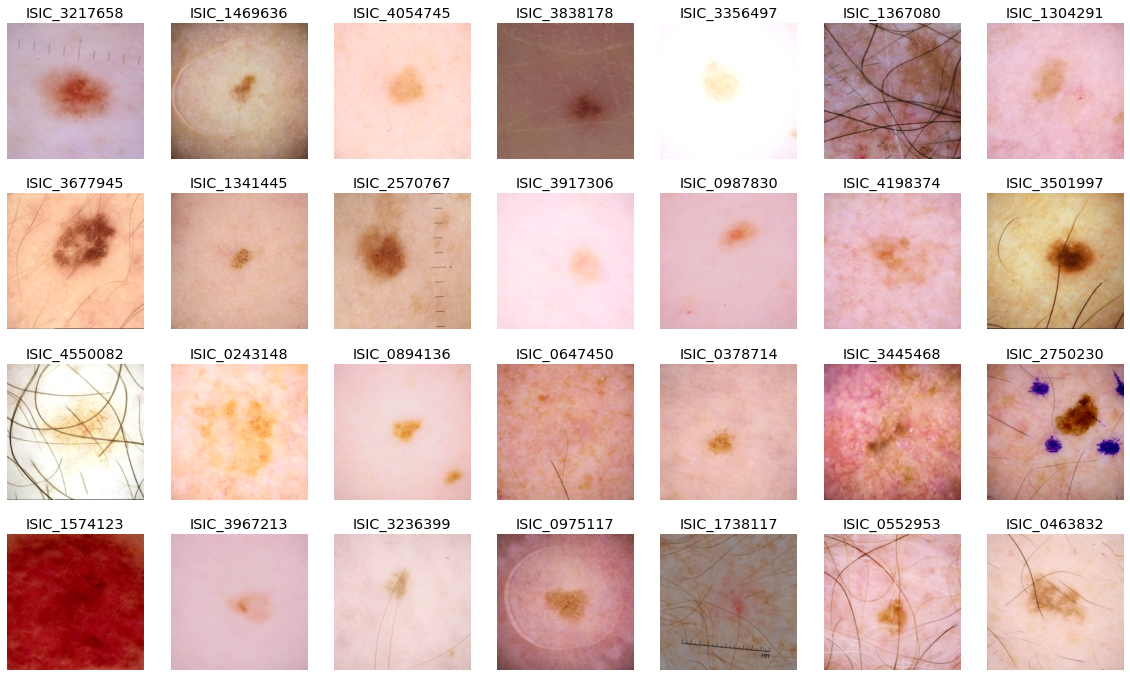

In [ ]:
FOLD_TO_TEST = 0
ds, _ = get_dataset(TFREC_TRAIN_SETS[FOLD_TO_TEST], 
                    augment=True, 
                    shuffle=True, 
                    repeat=True,
                    labeled=False,
                    dim=IMG_SIZES[FOLD_TO_TEST], 
                    batch_size=64)

# plot images
fig, axes = plt.subplots(4, 7, figsize=(20, 12))
images, names = next(iter(ds))
images = images.numpy()
i = 0
for row in axes:
    for ax in row:
        img = images[i] * 255
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        
        ax.imshow(img)
        ax.set_title(names[i].numpy().decode("utf-8"))
        ax.axis('off')
        i += 1

## Exploratory Data Analysis: Can EfficientNet B0 Learn?


Outputs from EfficientNet B0 are extracted and analyzed before being fed into Softmax or Sigmoid to generate probabilities for class predictions. 

This section explores the effectiveness of EfficientNet B0 by first extracting its outputs (prior to being fed to Sigmoid), and then projecting the extracted features to a 2D plane using PCA. Images close to each other (by Euclidean Distance) on the plot are rendered to observe their resemblance.   
  
![alt text](https://lh3.googleusercontent.com/q7Hc19iQ1-9waerXkTWXY4qMSUWVkkHUvoGmm-YY62j58f6RtbKZnWxBn7PJAzYAye8pbsnZ5myUaySAxmRDvVI6_A3pIrCMT1lN56z8L7niKCB9GHDv32w_C7G_pmUCAQ5hXJ85SvSOZf8f0JFGcDAGVE8Q9hLSbkJ3fcDS7sliNoaZXU0NaecBVN5W-y__IBATtyOksJpBoloa1YFgRGOeGVYaCvaSHGlca2CbwcO4QjohdbaYDvdfa3cw_k3cNZM2xnBUE-i50I4XUxVtROYgyGIhBuyq8AMC3PzbqubFfGjP8Kg7NWOowRujTw7fNETC66nQRzZWzoyAw03pvUT5hmGCEpn1prFvC7Uk1Dmfov0GF7i9fXL6ZPWUeIyZEtkIj2eR9pNKpxFZtM6wjuGz7QEE6SQApyVVmGBRejkpkqTef69qg-YPFIKgEB57YexmX6PMoU56kAJapv4kAwWlM2lZXi8KWK91RjKVyjlHpRw1d4zqdeJcgh0iM5B7nu_AkY8q3GBfnWhuMCXqGqjXxn-T4yAqkXhgBstWCJ4obBLSC1PBiZaPJVNsQNUFzdgYxl5rtWKqn-XCxXI9ZwoYZ1V60Ok6-ti05Xo3DR-cvoVhG6wMSob_7_3XecW4Xxc4jwidRVKSphN5mejCU5DxIi6UJZUmdCRAfWSnRlhznvlH75QZ_DQegqjnRd0=w1511-h642-no?authuser=0)

### Extraction Configurations

In [ ]:
BATCH_SIZE = 64
EPOCH = 1
IMG_SIZE = 128 # 128, 192, 256, 384, 512, 768, 1024

LOSS_FUNC = 0
EFF_NET = 0

RANDOM_AUG = False
SIGMOID_THD = 0.2
SAVE_WEIGHTS_ONLY = True
FL_ALPHA = 0.75

if IS_LOCAL:
    TFREC_TRAIN_SET = tf.io.gfile.glob(TFREC_DIR.format(IMG_SIZE) + 'train*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(KAGGLE_TFREC_GCS[IMG_SIZE] + '/train*.tfrec')
MODEL_SAVE_PATH = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_{epoch:1d}.h5'
EP1_MODEL_SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_1_solo.h5'
NPY_SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/npy/"

# function to plot the images within a pre-definedregion
def plot_region(region: np.ndarray, title: str, count: int = -1) -> None:
    img_names = img_name_arr[region]
    if count > 0:
        np.random.shuffle(img_names)
        len_ = img_names.shape[0] if img_names.shape[0] < count else count
        img_names = img_names[:len_]

    parser = TFRECParser()
    parser.load(TFREC_TRAIN_SET)
    print(title)
    parser.plot_images(img_names.tolist())

### One Single Epoch of Training on EfficientNet-B0

In [ ]:
print('Building model...')
K.clear_session() 
with strategy.scope():
    model = build_efns(dim=IMG_SIZE, 
                       ef=EFF_NET,
                       loss=LOSS_FUNC,
                       fl_alpha=FL_ALPHA)

# create checkpoints
cb = keras.callbacks.ModelCheckpoint(EP1_MODEL_SAVE_DIR, 
                                     verbose=1, 
                                     save_weights_only=SAVE_WEIGHTS_ONLY, 
                                     save_best_only=False,
                                     save_freq='epoch')
callbacks = [cb]
        
# --------------------------------------------------------------------------
# TRAINING

print('Training...')
ds_train, steps_train = get_dataset(TFREC_TRAIN_SET, 
                                    augment=RANDOM_AUG, 
                                    shuffle=True, 
                                    repeat=True,
                                    dim=IMG_SIZE, 
                                    batch_size=BATCH_SIZE)
history = model.fit(ds_train, 
                    epochs=EPOCH, 
                    callbacks=callbacks, 
                    steps_per_epoch=steps_train,
                    verbose=1)

Building model...
Training...
511/511 [==============================] - ETA: 0s - loss: 0.1781 - recall: 0.0293 - auc: 0.7019 - binary_accuracy: 0.9706
Epoch 00001: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_1_solo.h5
511/511 [==============================] - 27s 54ms/step - loss: 0.1781 - recall: 0.0293 - auc: 0.7019 - binary_accuracy: 0.9706


### Extracting Outputs From EfficientNet-B0 (Epoch 1)

In [ ]:
# SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/npy/'

print('Extracting... ', end='')

# build extractor
ds, _ = get_dataset(TFREC_TRAIN_SET, 
                    augment=False, 
                    shuffle=False, 
                    repeat=False,
                    labeled=False, 
                    return_img_names=False,
                    dim=IMG_SIZE, 
                    batch_size=64)
extractor = K.function([model.input],
                       [model.layers[1].output])

# extract from EfficientNet
outputs = []
for images, names in iter(ds):
    output = extractor(images)[0].tolist()
    outputs.extend(output)
outputs = np.array(outputs)

# laod img names
ds_img_names, _ = get_dataset(TFREC_TRAIN_SET, 
                              augment=False, 
                              repeat=False,
                              labeled=False, 
                              return_img_names=True,
                              dim=IMG_SIZE)
img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])

# load targets
ds_targets, _ = get_dataset(TFREC_TRAIN_SET,
                            augment=False, 
                            repeat=False, 
                            labeled=True, 
                            dim=IMG_SIZE, 
                            batch_size=64)
targets = [target.numpy() for img, target in iter(ds_targets.unbatch())]
targets = np.array(targets)

# save results
np,save(NPY_SAVE_DIR + 'outputs.npy', outputs)
np,save(NPY_SAVE_DIR + 'targets.npy', targets)
np,save(NPY_SAVE_DIR + 'img_names.npy', img_name_arr)

print('Complete!')

Extracting... Complete!


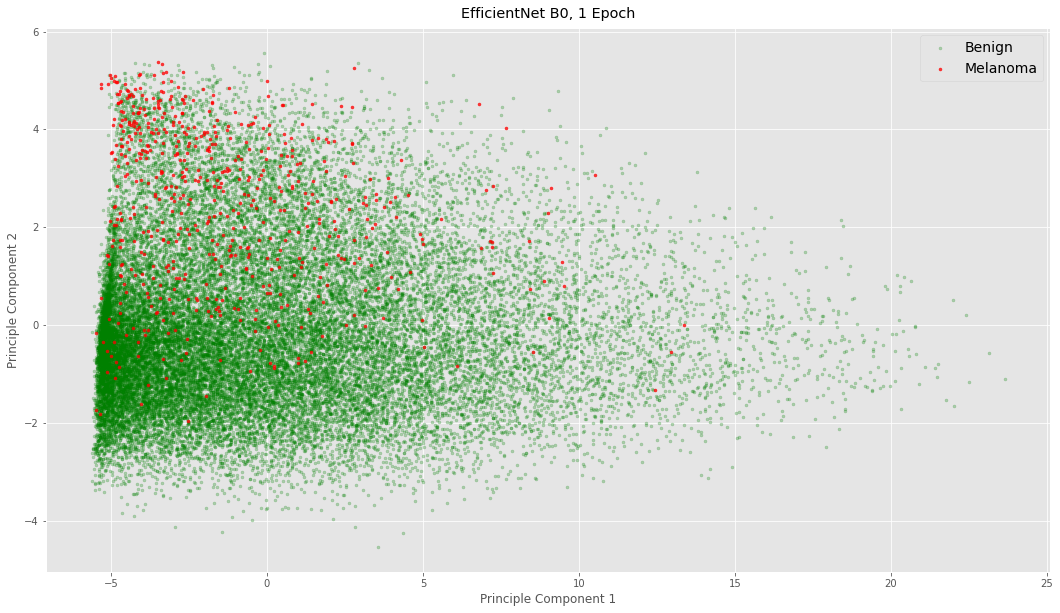

In [ ]:
# apply PCA and plot outputs
pca = PCA(n_components=2)
outputs_reduced = pca.fit_transform(outputs)

# plot
fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(outputs_reduced[targets == 0, 0], 
           outputs_reduced[targets == 0, 1], 
           marker='.',
           color=pltcolors.to_rgba('g', alpha=0.25),
           label='Benign')
ax.scatter(outputs_reduced[targets == 1, 0], 
           outputs_reduced[targets == 1, 1], 
           marker='.',
           color=pltcolors.to_rgba('r', alpha=.75),
           label='Melanoma')
ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')
ax.set_title('EfficientNet B0, 1 Epoch', pad=10)
ax.legend(fontsize=14)
pass

PCA_X > 20



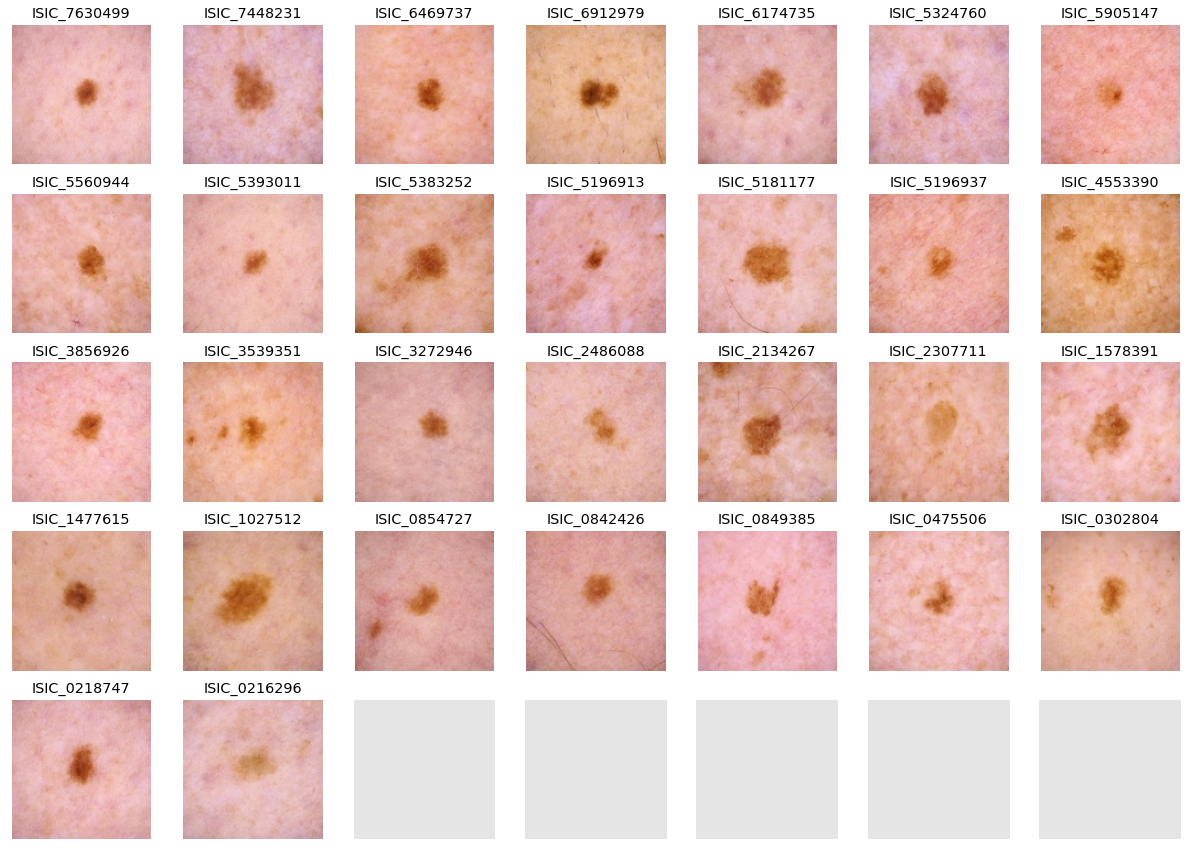

In [ ]:
r = outputs_reduced[:, 0] > 20
plot_region(r, 'PCA_X > 20\n')

-5 < PCA_X < -4.6, 4 < PCA_Y < 4.4



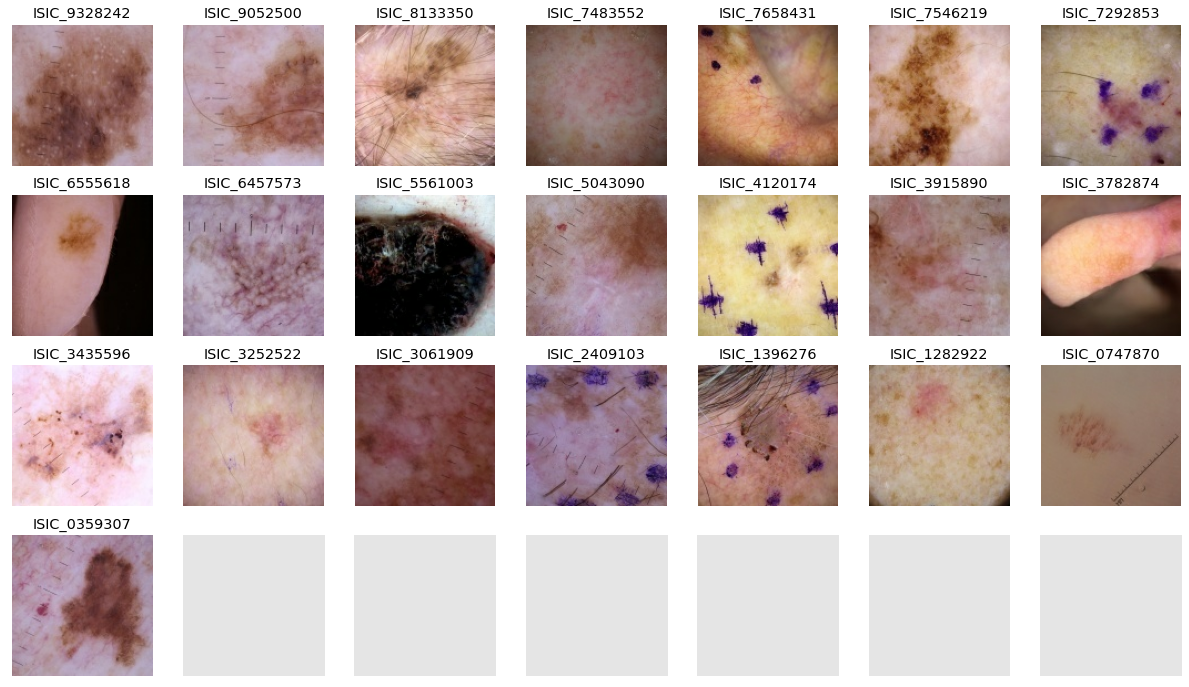

In [ ]:
x = outputs_reduced[:, 0]
y = outputs_reduced[:, 1]
r = ((-5 < x) & (x < -4.6)) & ((4 < y) & (y < 4.4))
img_name_arr[r].shape
plot_region(r, '-5 < PCA_X < -4.6, 4 < PCA_Y < 4.4\n')

### Plotting More Epochs

EfficientNet B0 is clearly picking up signla even after just one epoch of training (roughly 30,000+ images). The next logical question that follows is: Would EfficientNet B0 continue to learn with more epochs?  
  
Findings highlighted below show strong evidence that EfficientNet B0 continoues to learn and create clusters with more epochs. Interestingly, at the end of the 10th epoch, EfficientNet B0 is picking up signals so subtile that I can no longer visually observe the difference with my pair of untrained eyes. EfficientNet B0 is now on its way to become a dermatologist!

Special Note: The distribution of epoch 1 looks significantly different from the one above due to Keras' randomized weight initialization.

In [ ]:
print('Building model...')
K.clear_session() 
with strategy.scope():
    model = build_efns(dim=128, 
                       ef=EFF_NET,
                       loss=LOSS_FUNC,
                       fl_alpha=FL_ALPHA)

Building model...


In [ ]:
# model save files
SAVED_MODELS = ['tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_1.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_2.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_3.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_4.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_5.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_6.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_7.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_8.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_9.h5',
                'tim/cnn/_saves/cnn_efn/fea_extract/model_efnb0_epoch_10.h5']

# laod img names
ds_img_names, _ = get_dataset(TFREC_TRAIN_SET, 
                              augment=False, 
                              repeat=False,
                              labeled=False, 
                              return_img_names=True,
                              dim=IMG_SIZE)
img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])

# load targets
ds_targets, _ = get_dataset(TFREC_TRAIN_SET,
                            augment=False, 
                            repeat=False, 
                            labeled=True, 
                            dim=IMG_SIZE, 
                            batch_size=64)
targets = [target.numpy() for img, target in iter(ds_targets.unbatch())]
targets = np.array(targets)

for i, m in enumerate(SAVED_MODELS):
    # build extractor
    model.load_weights(REPO_ROOT + m)
    ds, _ = get_dataset(TFREC_TRAIN_SET, 
                        augment=False, 
                        shuffle=False, 
                        repeat=False,
                        labeled=False, 
                        return_img_names=False,
                        dim=IMG_SIZE, 
                        batch_size=64)
    extractor = K.function([model.input],
                        [model.layers[1].output])

    # extract embedding from EfficientNet
    outputs = []
    for images, names in iter(ds):
        output = extractor(images)[0].tolist()
        outputs.extend(output)
    outputs = np.array(outputs)

    # apply PCA and plot outputs
    pca = PCA(n_components=2)
    outputs_reduced = pca.fit_transform(outputs)

    # plot
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.scatter(outputs_reduced[targets == 0, 0], 
            outputs_reduced[targets == 0, 1], 
            marker='.',
            color=pltcolors.to_rgba('g', alpha=0.25),
            label='Benign')
    ax.scatter(outputs_reduced[targets == 1, 0], 
            outputs_reduced[targets == 1, 1], 
            marker='.',
            color=pltcolors.to_rgba('r', alpha=.75),
            label='Melanoma')
    ax.set_xlabel('Principle Component 1')
    ax.set_ylabel('Principle Component 2')
    ax.set_title('EfficientNet B0, Epoch {:d}'.format(i+1), pad=10)
    ax.legend(fontsize=14)

    plt.show()
    print('')
    pass

Output hidden; open in https://colab.research.google.com to view.

### 10 Epochs Later

15 < PCA_X < 20, 5 < PCA_Y < 10



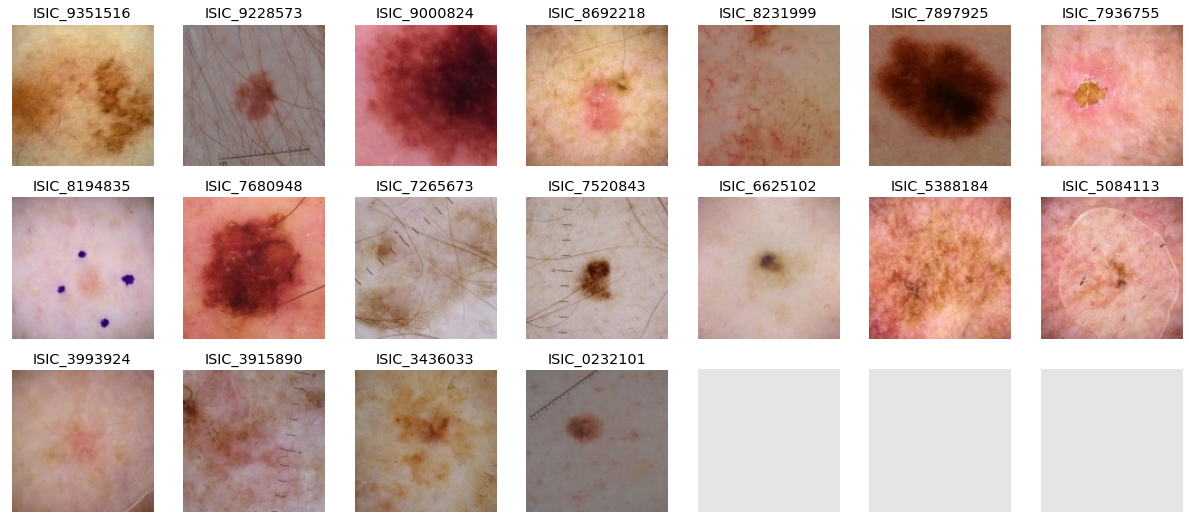

In [ ]:
x = outputs_reduced[:, 0]
y = outputs_reduced[:, 1]

r = (((15 < x) & (x < 20)) & 
     ((5 < y) & (y < 10)))

plot_region(r, '15 < PCA_X < 20, 5 < PCA_Y < 10\n')

-0.8 < PCA_X < 0, 1.3 < PCA_Y < 1.8



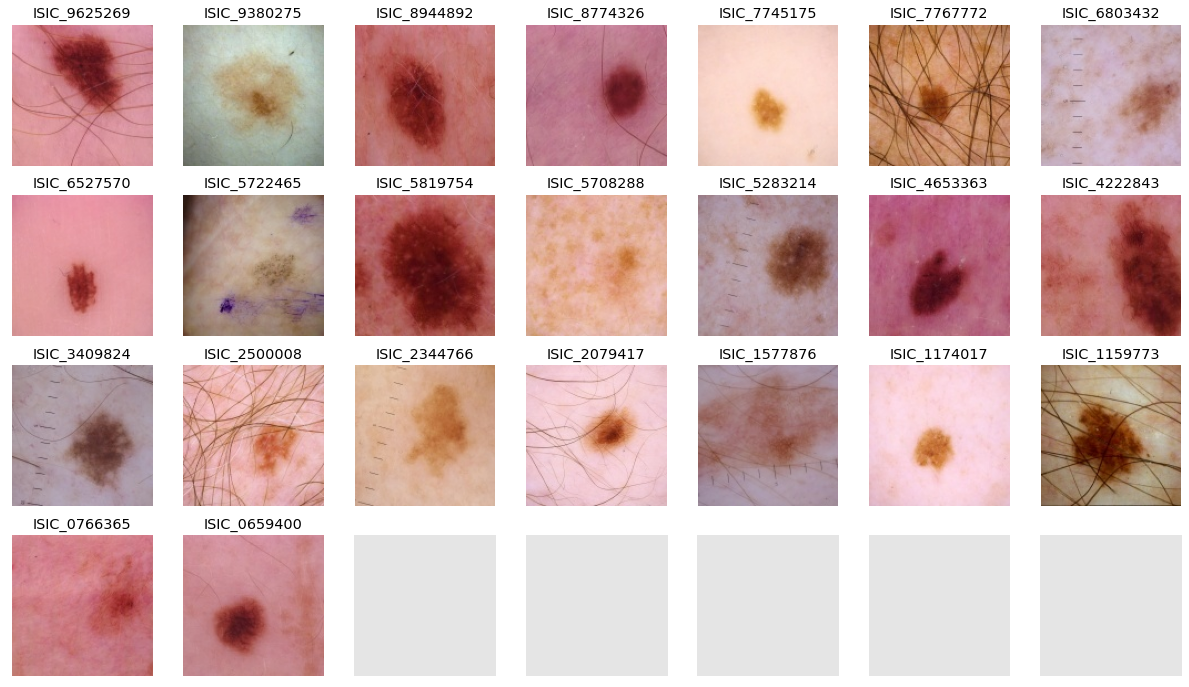

In [ ]:
x = outputs_reduced[:, 0]
y = outputs_reduced[:, 1]
r = (((-0.8 < x) & (x < 0)) & 
     ((1.3 < y) & (y < 1.8)))

plot_region(r, '-0.8 < PCA_X < 0, 1.3 < PCA_Y < 1.8\n')

## Modeling: K-Fold Cross-Validation

### K-Fold Cross-Validation


--------------------------------------------------
FOLD 1
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20
EfficientNetB7, Binary Crossentropy

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.0256 - binary_accuracy: 0.9720 - loss: 0.1789 - auc: 0.6957
Epoch 00001: val_loss improved from inf to 0.16922, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_0.h5
409/409 [==============================] - 155s 378ms/step - recall: 0.0256 - binary_accuracy: 0.9720 - loss: 0.1789 - auc: 0.6957 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.9822 - val_loss: 0.1692 - val_auc: 0.8186
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.0087 - binary_accuracy: 0.9806 - loss: 0.1698 - auc: 0.7770
Epoch 00002: val_loss did not improve from 0.16922
409/409 [==============================] - 139s 340ms/step - recall: 0.0087 - binary_accuracy:

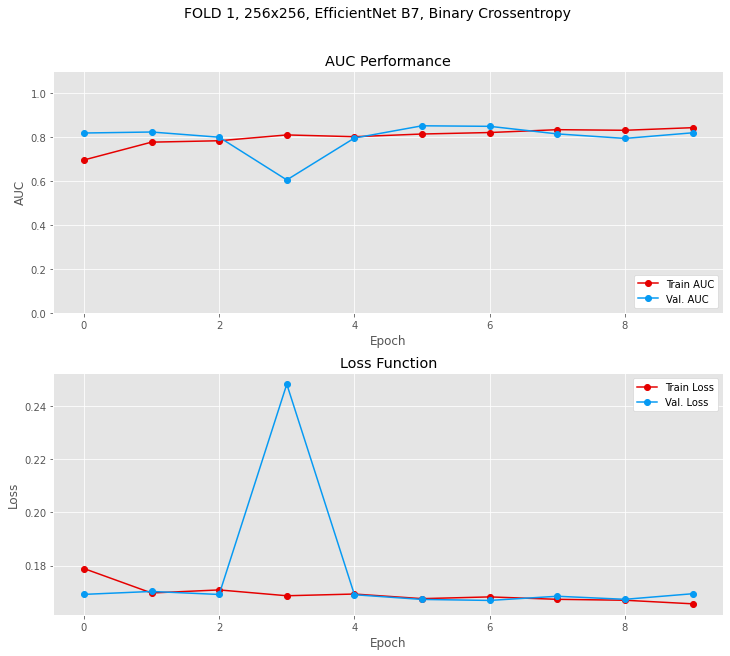


--------------------------------------------------
FOLD 2
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20, FL Alpha 0.75
EfficientNetB7, Focal Loss

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.8043 - binary_accuracy: 0.5047 - loss: 0.0162 - auc: 0.6894
Epoch 00001: val_loss did not improve from inf
409/409 [==============================] - 144s 353ms/step - recall: 0.8043 - binary_accuracy: 0.5047 - loss: 0.0162 - auc: 0.6894 - val_recall: 0.4872 - val_binary_accuracy: 0.3413 - val_loss: inf - val_auc: 0.5157
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.8253 - binary_accuracy: 0.5247 - loss: 0.0138 - auc: 0.7372
Epoch 00002: val_loss improved from inf to 0.01354, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_1.h5
409/409 [==============================] - 129s 316ms/step - recall: 0.8253 - binary_accuracy: 0.52

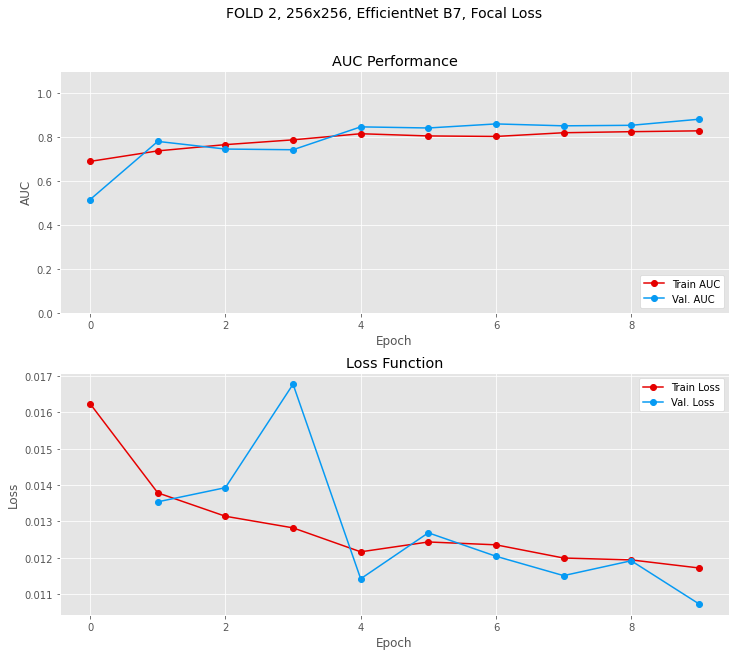


--------------------------------------------------
FOLD 3
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20
EfficientNetB4, Binary Crossentropy

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.0170 - binary_accuracy: 0.9729 - loss: 0.1766 - auc: 0.7294
Epoch 00001: val_loss improved from inf to 0.17066, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_2.h5
409/409 [==============================] - 90s 220ms/step - recall: 0.0170 - binary_accuracy: 0.9729 - loss: 0.1766 - auc: 0.7294 - val_recall: 0.1111 - val_binary_accuracy: 0.9730 - val_loss: 0.1707 - val_auc: 0.8443
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.0237 - binary_accuracy: 0.9807 - loss: 0.1686 - auc: 0.8159
Epoch 00002: val_loss improved from 0.17066 to 0.16759, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/m

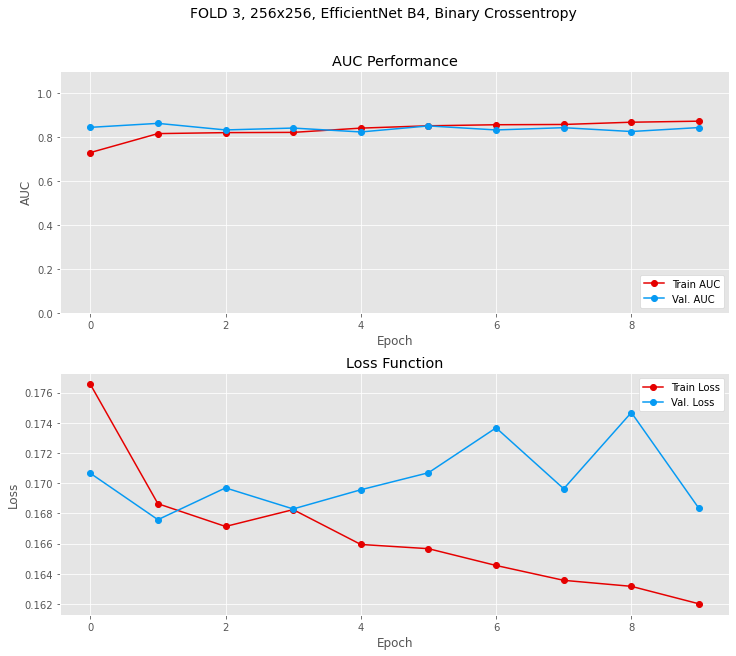


--------------------------------------------------
FOLD 4
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20, FL Alpha 0.75
EfficientNetB4, Focal Loss

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.8333 - binary_accuracy: 0.5118 - loss: 0.0150 - auc: 0.7250
Epoch 00001: val_loss improved from inf to 0.01116, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_3.h5
409/409 [==============================] - 82s 200ms/step - recall: 0.8333 - binary_accuracy: 0.5118 - loss: 0.0150 - auc: 0.7250 - val_recall: 0.9739 - val_binary_accuracy: 0.5599 - val_loss: 0.0112 - val_auc: 0.8590
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.8750 - binary_accuracy: 0.5381 - loss: 0.0130 - auc: 0.7831
Epoch 00002: val_loss did not improve from 0.01116
409/409 [==============================] - 67s 163ms/step - recall: 0.8750 - binary_accuracy:

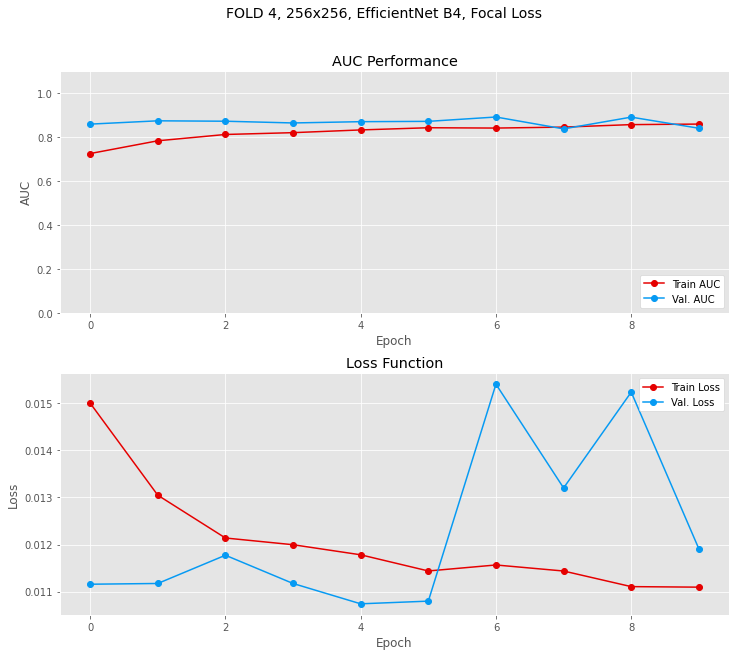


--------------------------------------------------
FOLD 5
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20
EfficientNetB0, Binary Crossentropy

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.0213 - binary_accuracy: 0.9725 - loss: 0.1770 - auc: 0.7321
Epoch 00001: val_loss improved from inf to 0.17792, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_4.h5
409/409 [==============================] - 50s 122ms/step - recall: 0.0213 - binary_accuracy: 0.9725 - loss: 0.1770 - auc: 0.7321 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.9795 - val_loss: 0.1779 - val_auc: 0.6269
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.0383 - binary_accuracy: 0.9804 - loss: 0.1700 - auc: 0.7952
Epoch 00002: val_loss improved from 0.17792 to 0.16706, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_2332

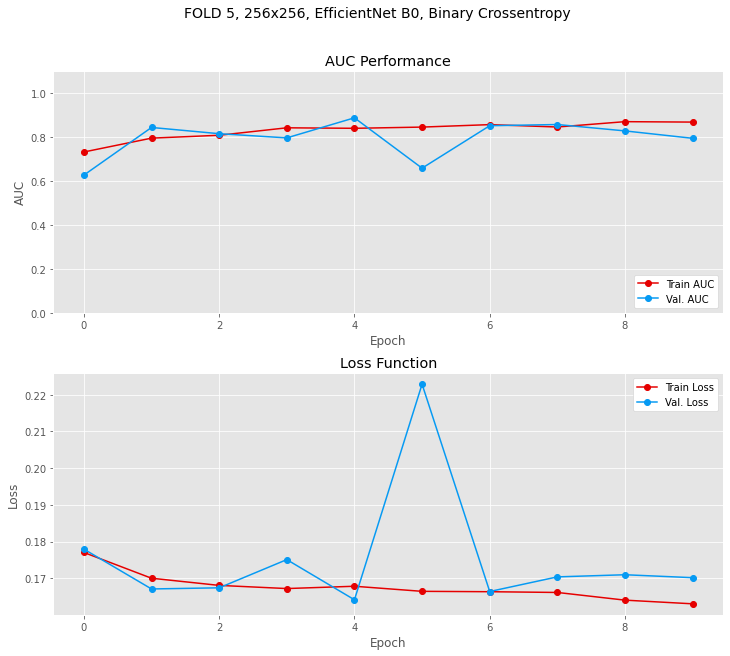

In [ ]:
SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/'

# create folder for saving best models
save_dir = ''
if BEST_MODEL:
    st = datetime.utcnow().strftime('kcv_utc_%m%d_%H%M%S')
    save_dir = SAVE_DIR + st
    os.mkdir(save_dir)
    save_dir += '/'

# lists to save img preds
oof_folds = [] 
oof_pred_proba = []
oof_targets = []
oof_img_names = []
oof_loss_functions = []

# lists to save model info
m_folds = []
m_auc_tta = [] # validation auc with tta
m_auc_no_tta = []
m_sigmoid_thd = []
m_acc = [] # validation accuracy
m_recalls = []
m_loss = []

# build & execute k-folds
skf = KFold(n_splits=FOLDS,
            shuffle=True,
            random_state=SEED)
folds = skf.split(np.arange(TFREC_SPLITS)) 
for fold, (i_train, i_valid) in enumerate(folds):
    # print fold info
    print('')
    print('-' * 50)
    print('FOLD', fold + 1)
    print('-' * 50)
    if LOSS_FUNCTIONS[fold] == 1:
        print('Image Size {}, Batch Size {}, Sigmoid {:.2f}, FL Alpha {:.2f}'.format(IMG_SIZES[fold],
                                                                                    BATCH_SIZES[fold],
                                                                                    SIGMOID_THD,
                                                                                    FL_ALPHA))
    else:
        print('Image Size {}, Batch Size {}, Sigmoid {:.2f}'.format(IMG_SIZES[fold],
                                                                    BATCH_SIZES[fold],
                                                                    SIGMOID_THD))
    print('EfficientNetB{}, {}'.format(EFF_NETS[fold],
                                       LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]))
    
    # --------------------------------------------------------------------------
    # BUILD DATASETS

    # get train tfrec files
    files = TFREC_TRAIN_SETS[fold]
    files_train = [files[i] for i in i_train]
    np.random.shuffle(files_train)
    files_valid = [files[i] for i in i_valid]
    
    # --------------------------------------------------------------------------
    # BUILD MODEL
    
    # clear current TF graph to prevent memory leak
    K.clear_session() 
    # use TPU if possible: https://tinyurl.com/y7pkqrat
    with strategy.scope():
        model = build_efns(dim=IMG_SIZES[fold], 
                           ef=EFF_NETS[fold],
                           loss=LOSS_FUNCTIONS[fold])
    
    # save best model
    callbacks = []
    cb = keras.callbacks.ModelCheckpoint(save_dir + 'model_fold_{}.h5'.format(fold), 
                                         monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=BEST_MODEL,
                                         save_weights_only=True, 
                                         mode='min', 
                                         save_freq='epoch')
    callbacks.append(cb)

    # --------------------------------------------------------------------------
    # TRAINING
    
    print('\nTraining...')

    # this is an ugly fix to the bug on focal loss and the fact that you cannot run
    # gradient norm clipping on distributed strategy
    # https://tinyurl.com/y5ojf9tb
    drop_remainder = False
    if LOSS_FUNCTIONS[fold] == 1:
        drop_remainder = True
    
    ds_train, steps_train = get_dataset(files_train, 
                                        augment=RANDOM_AUG, 
                                        shuffle=True, 
                                        repeat=True,
                                        dim=IMG_SIZES[fold], 
                                        batch_size=BATCH_SIZES[fold],
                                        drop_remainder=drop_remainder)
    ds_valid, steps_valid = get_dataset(files_valid,
                                        augment=False,
                                        shuffle=False,
                                        repeat=False,
                                        dim=IMG_SIZES[fold],
                                        batch_size=BATCH_SIZES[fold],
                                        drop_remainder=drop_remainder)
    history = model.fit(ds_train, 
                        epochs=EPOCHS[fold], 
                        callbacks=callbacks, 
                        steps_per_epoch=steps_train,
                        validation_data=ds_valid, 
                        verbose=1)

    print('\nLoading best model...')
    model.load_weights(save_dir + 'model_fold_{}.h5'.format(fold))
    
    # --------------------------------------------------------------------------
    # PREDICTIONS
        
    print('\nPredicting OOF with TTA...')
    # perform TTA
    ds_valid, steps_valid = get_dataset(files_valid,
                                        labeled=False,
                                        return_img_names=False,
                                        augment=RANDOM_AUG,
                                        repeat=True,
                                        shuffle=False,
                                        dim=IMG_SIZES[fold],
                                        batch_size=BATCH_SIZES[fold])

    if RANDOM_AUG:
        steps_valid = TTA_STEPS * steps_valid
    preds = model.predict(ds_valid,
                          steps=steps_valid,
                          verbose=1)

    # cut off the "reminders" in the last batch 
    ct_valid = count_examples(files_valid)
    if RANDOM_AUG:
        preds = preds[:TTA_STEPS * ct_valid,] 
    else:
        preds = preds[:ct_valid,] 

    # get oof probabilities; avg pred. proba. over TTAs
    preds_reshape = preds
    if RANDOM_AUG:
        # reshape: each column is one round of prediction
        preds_reshape = preds_reshape.reshape((ct_valid, TTA_STEPS), order='F')
    preds_avg = np.mean(preds_reshape, axis=1)

    # get oof targets
    ds_targets, _ = get_dataset(files_valid, 
                                augment=False, 
                                repeat=False, 
                                labeled=True, 
                                dim=IMG_SIZES[fold])
    targets = [target.numpy() for img, target in iter(ds_targets.unbatch())]
    targets = np.array(targets)

    # get oof fold, img names, and loss functions
    ds_img_names, _ = get_dataset(files_valid, 
                                  augment=False, 
                                  repeat=False,
                                  labeled=False, 
                                  return_img_names=True,
                                  dim=IMG_SIZES[fold])
    img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])
    fold_arr = np.zeros_like(targets, dtype='int8') + fold
    loss_arr = np.empty_like(targets, dtype='U')
    loss_func_name = LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]
    loss_arr = np.char.add(loss_arr, loss_func_name)

    # print oof auc
    auc_tta = roc_auc_score(targets, preds_avg)
    auc_no_tta = np.max(history.history['val_auc'][-1])
    print('FOLD {}:'.format(fold + 1))
    print('OOF AUC without TTA =', auc_no_tta)
    print('OOF AUC with TTA =', auc_tta)

    # print report
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= SIGMOID_THD] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print(classification_report(targets, pred_labels))

    # save img-level pred results
    oof_folds.append(fold_arr)
    oof_img_names.append(img_name_arr)
    oof_targets.append(targets)
    oof_pred_proba.append(preds_avg)
    oof_loss_functions.append(loss_arr)

    # save model info
    m_folds.append(fold)
    m_auc_tta.append(auc_tta)
    m_auc_no_tta.append(auc_no_tta)
    m_sigmoid_thd.append(SIGMOID_THD)
    m_acc.append(report['accuracy'])
    m_recalls.append(report['1']['recall'])
    m_loss.append(loss_func_name)

    # --------------------------------------------------------------------------
    # PLOT PERFORMANCE

    # plot performance metrics
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('FOLD {}, {}x{}, EfficientNet B{}, {}'.format(fold + 1,
                                                            IMG_SIZES[fold],
                                                            IMG_SIZES[fold],
                                                            EFF_NETS[fold],
                                                            LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]),
                fontsize=14,
                y=0.97)
    fig.subplots_adjust(hspace=.25)


    # plot AUC
    axes[0].plot(np.arange(EPOCHS[fold]),
            history.history['auc'],
            linestyle='solid',
            marker='o',
            label='Train AUC',
            color='xkcd:red')
    axes[0].plot(np.arange(EPOCHS[fold]),
            history.history['val_auc'],
            linestyle='solid',
            marker='o',
            label='Val. AUC',
            color='xkcd:azure')
    axes[0].set_title('AUC Performance')
    axes[0].set_ylabel('AUC')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylim(top=1.1, bottom=0)
    axes[0].legend(loc=4, 
                frameon=True, 
                framealpha=1, 
                fancybox=True, 
                facecolor='white')

    # plot loss function
    axes[1].plot(np.arange(EPOCHS[fold]),
            history.history['loss'],
            linestyle='solid',
            marker='o',
            label='Train Loss',
            color='xkcd:red')
    axes[1].plot(np.arange(EPOCHS[fold]),
            history.history['val_loss'],
            linestyle='solid',
            marker='o',
            label='Val. Loss',
            color='xkcd:azure')
    axes[1].set_title('Loss Function')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc=1, 
                frameon=True, 
                framealpha=1, 
                fancybox=True, 
                facecolor='white')
    plt.show()
    pass

### Testing Different Sigmoid Thresholds 

In [ ]:
THDS = [0.1, 0.2, 0.5]

for thd in THDS:
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= thd] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print("\nSigmoid THD = {:.2f}:".format(thd))
    print(classification_report(targets, pred_labels))


Sigmoid THD = 0.10:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6424
           1       0.17      0.37      0.23       115

    accuracy                           0.96      6539
   macro avg       0.58      0.67      0.61      6539
weighted avg       0.97      0.96      0.97      6539


Sigmoid THD = 0.20:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6424
           1       0.54      0.11      0.19       115

    accuracy                           0.98      6539
   macro avg       0.76      0.56      0.59      6539
weighted avg       0.98      0.98      0.98      6539


Sigmoid THD = 0.50:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6424
           1       0.00      0.00      0.00       115

    accuracy                           0.98      6539
   macro avg       0.49      0.50      0.50      6539
weighted av

### Saving K-Fold Cross-Validation Results

In [ ]:
SAVE_DIR_OOF = save_dir
SAVE_DIR_MODEL = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/'

preds = np.concatenate(oof_pred_proba) 
targets = np.concatenate(oof_targets)
names = np.concatenate(oof_img_names)
folds = np.concatenate(oof_folds)
loss = np.concatenate(oof_loss_functions)

auc = roc_auc_score(targets, preds)
print('Overall OOF AUC with TTA = %.3f'%auc)

# save oof results
df_oof = pd.DataFrame(dict(image=names, 
                           target=targets, 
                           prediction=preds, 
                           fold=folds,
                           loss_function=loss))
df_oof.to_csv(SAVE_DIR_OOF + 'oof.csv', index=False)
print('\nOOF:')
display(df_oof.head())

# save models
df_models = pd.DataFrame(dict(fold=m_folds,
                              auc_tta=m_auc_tta,
                              auc_no_tta=m_auc_no_tta,
                              sigmoid_thd=m_sigmoid_thd,
                              accuracy=m_acc,
                              recalls=m_recalls,
                              loss_function=m_loss))
df_models.to_csv(SAVE_DIR_OOF + 'best_models.csv', index=False)
print('\nBest Models:')
display(df_models)

# append model info to global log
st = datetime.utcnow().strftime('utc_%m%d_%H%M%S')
df_models = pd.DataFrame(dict(fold=m_folds,
                              auc_tta=m_auc_tta,
                              auc_no_tta=m_auc_no_tta,
                              sigmoid_thd=m_sigmoid_thd,
                              accuracy=m_acc,
                              recalls=m_recalls,
                              loss_function=m_loss,
                              save_time=st))

global_model_log = SAVE_DIR_MODEL + 'best_models.csv'
include_header = not os.path.isfile(global_model_log)
df_models.to_csv(global_model_log, 
                 index=False, 
                 mode='a',
                 header=include_header)

Overall OOF AUC with TTA = 0.751

OOF:


image  target  prediction  fold        loss_function
0  ISIC_0077735       0    0.028678     0  Binary Crossentropy
1  ISIC_0099474       0    0.030259     0  Binary Crossentropy
2  ISIC_0079038       0    0.029155     0  Binary Crossentropy
3  ISIC_0090279       0    0.029873     0  Binary Crossentropy
4  ISIC_0148465       0    0.026260     0  Binary Crossentropy


Best Models:


fold   auc_tta  auc_no_tta  ...  accuracy   recalls        loss_function
0     0  0.852289    0.819504  ...  0.978091  0.094828  Binary Crossentropy
1     1  0.878429    0.881257  ...  0.696584  0.923077           Focal Loss
2     2  0.861925    0.843392  ...  0.974801  0.136752  Binary Crossentropy
3     3  0.874758    0.840267  ...  0.590777  0.948276           Focal Loss
4     4  0.899668    0.794515  ...  0.982719  0.113043  Binary Crossentropy

[5 rows x 7 columns]

## Predicting Test Dataset

### Full-Dataset Model Training

In [ ]:
BATCH_SIZE = 64
EPOCH = 7
IMG_SIZE = 256 # 128, 192, 256, 384, 512, 768, 1024

LOSS_FUNC = 1
EFF_NET = 7

RANDOM_AUG = False
SIGMOID_THD = 0.2
SAVE_WEIGHTS_ONLY = True
FL_ALPHA = 0.75

SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/'
if IS_LOCAL:
    TFREC_TRAIN_SET = tf.io.gfile.glob(TFREC_DIR.format(IMG_SIZE) + 'train*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(KAGGLE_TFREC_GCS[IMG_SIZE] + '/train*.tfrec')

# --------------------------------------------------------------------------
# BUILD MODEL

print('Building model...')
K.clear_session() 
with strategy.scope():
    model = build_efns(dim=IMG_SIZE, 
                       ef=EFF_NET,
                       loss=LOSS_FUNC,
                       fl_alpha=FL_ALPHA)

# create save dir
st = datetime.utcnow().strftime('fm_utc_%m%d_%H%M%S')
save_dir = SAVE_DIR + st
os.mkdir(save_dir)
save_dir += '/'

# create checkpoints
cb = keras.callbacks.ModelCheckpoint(save_dir + 'model.h5', 
                                     verbose=1, 
                                     save_weights_only=SAVE_WEIGHTS_ONLY, 
                                     save_freq='epoch')
callbacks = [cb]
        
# --------------------------------------------------------------------------
# TRAINING

print('Training...')
ds_train, steps_train = get_dataset(TFREC_TRAIN_SET, 
                                    augment=RANDOM_AUG, 
                                    shuffle=True, 
                                    repeat=True,
                                    dim=IMG_SIZE, 
                                    batch_size=BATCH_SIZE)
history = model.fit(ds_train, 
                    epochs=EPOCH, 
                    callbacks=callbacks, 
                    steps_per_epoch=steps_train,
                    verbose=1)

Building model...
258441216/258434480 [==============================] - 4s 0us/step
Training...
Epoch 1/7
511/511 [==============================] - ETA: 0s - binary_accuracy: 0.5183 - auc: 0.7104 - loss: 0.0154 - recall: 0.7928
Epoch 00001: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/fm_utc_0723_183646/model.h5
511/511 [==============================] - 147s 287ms/step - binary_accuracy: 0.5183 - auc: 0.7104 - loss: 0.0154 - recall: 0.7928
Epoch 2/7
511/511 [==============================] - ETA: 0s - binary_accuracy: 0.5484 - auc: 0.7548 - loss: 0.0136 - recall: 0.8299
Epoch 00002: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/fm_utc_0723_183646/model.h5
511/511 [==============================] - 149s 291ms/step - binary_accuracy: 0.5484 - auc: 0.7548 - loss: 0.0136 - recall: 0.8299
Epoch 3/7
511/511 [==============================] - ETA: 0s - binary_accuracy: 0.5812 - auc: 0.8086 - loss: 0.0124 - recall: 0.8774
Epoch 00003: s

### Final Prediction & Kaggle Submission

In [ ]:
LOAD_MODEL = True

# 128, 192, 256, 384, 512, 768, 1024
TEST_IMG_DIM = 256
BATCH_SIZE = 64
MODEL_H5 = REPO_ROOT + 'tim/cnn/_saves/submissions/submitted/fm_utc_0718_083004/last_model.h5'

SAVE_DIR_SUBMISSION = REPO_ROOT + 'tim/cnn/_saves/submissions/'
if IS_LOCAL:
    TFREC_TEST_SET = tf.io.gfile.glob(TFREC_DIR.format(TEST_IMG_DIM) + 'test*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(KAGGLE_TFREC_GCS[TEST_IMG_DIM] + '/test*.tfrec')

# ------------------------------------------------------------------------------
# PREDICTION

# load model
if LOAD_MODEL:
    print('Loading saved model...')
    K.clear_session() 
    with strategy.scope():
        model = keras.models.load_model(MODEL_H5,
                                           custom_objects={'focal_loss_fixed': focal_loss(alpha=0.75, gamma=2)})

# predict test dataset
ds_test, steps = get_dataset(TFREC_TRAIN_SET,
                             labeled=False,
                             return_img_names=False,
                             augment=RANDOM_AUG,
                             repeat=True,
                             shuffle=False,
                             dim=TEST_IMG_DIM,
                             batch_size=BATCH_SIZE)
if RANDOM_AUG:
    steps = TTA_STEPS * steps
preds = model.predict(ds_test, steps=steps, verbose=1)

# cut off the "reminders" in the last batch 
ct_test = count_examples(TFREC_TRAIN_SET)
if RANDOM_AUG:
    preds = preds[:TTA_STEPS * ct_test,] 
else:
    preds = preds[:ct_test,] 

# get oof probabilities; avg pred. proba. over TTAs
preds_reshape = preds
if RANDOM_AUG:
    # reshape: each column is one round of prediction
    preds_reshape = preds_reshape.reshape((ct_test, TTA_STEPS), order='F')
preds_avg = np.mean(preds_reshape, axis=1)

# ------------------------------------------------------------------------------
# GET IMAGE NAMES

ds_img_names, steps = get_dataset(TFREC_TRAIN_SET,
                                  labeled=False,
                                  return_img_names=True,
                                  augment=RANDOM_AUG,
                                  repeat=False,
                                  shuffle=False,
                                  dim=TEST_IMG_DIM)
img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])

# ------------------------------------------------------------------------------
# SAVE TO CSV

submission = pd.DataFrame(dict(image_name=img_name_arr, 
                               target=preds_avg))
submission.sort_values('image_name', inplace= True) 
st = datetime.utcnow().strftime('utc_%m%d_%H%M%S')
submission.to_csv(SAVE_DIR_SUBMISSION + 'submission_' + st + '.csv', index=False)
submission.head()

Loading saved model...
1720/1720 [==============================] - 160s 93ms/step


image_name    target
9905  ISIC_0052060  0.064134
1443  ISIC_0052349  0.033001
3120  ISIC_0058510  0.038070
4870  ISIC_0073313  0.027401
5494  ISIC_0073502  0.099102

## Bonus: Logistic Regression

### Model Configs

In [ ]:
BATCH_SIZE = 64
EPOCH = 10
IMG_SIZE = 256 # 128, 192, 256, 384, 512, 768, 1024

SIGMOID_THD = 0.2
DEV_SET_FILE_COUNT = 3
LABEL_SMOOTHING = 0.05

LEARN_RATE = 0.001
SIGMOID_THD = 0.2

# prep datasets
if IS_LOCAL:
    TFREC_TEST_SET = tf.io.gfile.glob(TFREC_DIR.format(IMG_SIZE) + 'train*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(KAGGLE_TFREC_GCS[IMG_SIZE] + '/train*.tfrec')
random.shuffle(TFREC_TRAIN_SET)
TFREC_DEV_SET = TFREC_TRAIN_SET[:DEV_SET_FILE_COUNT]
TFREC_TRAIN_SET = TFREC_TRAIN_SET[DEV_SET_FILE_COUNT:]

# function to build the logistic model
def build_logistic(dim: int, 
                    sig_thd: float = 0.5,
                    lr: float = 0.001,
                    label_smoothing: float = 0.05) -> Sequential:

    loss_func = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    
    m = Sequential()
    m.add(InputLayer(input_shape=(dim, dim, 3)))
    m.add(Flatten())
    m.add(Dense(1, activation='sigmoid')) 
    
    # compile model
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=loss_func, 
              metrics=[AUC(),
                       BinaryAccuracy(threshold=sig_thd),
                       Recall(thresholds=sig_thd)])
    return m

### Training

In [ ]:
print('Building model...')
keras.backend.clear_session() 
with strategy.scope():
    model = build_logistic(dim=IMG_SIZE,
                           sig_thd=SIGMOID_THD,
                           lr=LEARN_RATE,
                           label_smoothing=LABEL_SMOOTHING)
    
print('Training...')
ds_train, steps_train = get_dataset(TFREC_TRAIN_SET, 
                                    augment=False, 
                                    shuffle=True, 
                                    repeat=True,
                                    dim=IMG_SIZE, 
                                    batch_size=BATCH_SIZE)
history = model.fit(ds_train, 
                    epochs=EPOCH, 
                    steps_per_epoch=steps_train,
                    verbose=1)

Building model...
Training...
Epoch 1/10
409/409 [==============================] - 9s 21ms/step - loss: 5.8565 - recall: 0.0495 - auc: 0.5014 - binary_accuracy: 0.9375
Epoch 2/10
409/409 [==============================] - 9s 21ms/step - loss: 5.5843 - recall: 0.0370 - auc: 0.4963 - binary_accuracy: 0.9398
Epoch 3/10
409/409 [==============================] - 9s 21ms/step - loss: 5.0186 - recall: 0.0804 - auc: 0.5181 - binary_accuracy: 0.9416
Epoch 4/10
409/409 [==============================] - 8s 19ms/step - loss: 5.4230 - recall: 0.0677 - auc: 0.5101 - binary_accuracy: 0.9378
Epoch 5/10
409/409 [==============================] - 8s 19ms/step - loss: 5.1865 - recall: 0.0647 - auc: 0.5079 - binary_accuracy: 0.9381
Epoch 6/10
409/409 [==============================] - 8s 20ms/step - loss: 5.2039 - recall: 0.0607 - auc: 0.5115 - binary_accuracy: 0.9412
Epoch 7/10
409/409 [==============================] - 8s 20ms/step - loss: 5.6283 - recall: 0.0558 - auc: 0.5066 - binary_accuracy: 0.93

### Predicting Test Dataset

In [ ]:
print('\nPredicting...')
# perform TTA
ds_valid, steps_valid = get_dataset(TFREC_DEV_SET,
                                    labeled=False,
                                    return_img_names=False,
                                    augment=False,
                                    repeat=True,
                                    shuffle=False,
                                    dim=IMG_SIZE,
                                    batch_size=BATCH_SIZE)

preds = model.predict(ds_valid,
                        steps=steps_valid,
                        verbose=1)

# cut off the "reminders" in the last batch 
ct_valid = count_examples(TFREC_DEV_SET)
preds = preds[:ct_valid,] 

# get oof probabilities
preds_reshape = preds
preds_avg = np.mean(preds_reshape, axis=1)

# get oof targets
ds_targets, _ = get_dataset(TFREC_DEV_SET, 
                            augment=False, 
                            repeat=False, 
                            labeled=True, 
                            dim=IMG_SIZE,
                            batch_size=BATCH_SIZE)
targets = [target.numpy() for img, target in iter(ds_targets.unbatch())]
targets = np.array(targets)

# print oof auc
auc_no_tta = np.max(history.history['auc'])
print('AUC =', auc_no_tta)

# print report
pred_labels = np.zeros(preds_avg.shape[0])
pred_labels[preds_avg >= SIGMOID_THD] = 1
report = classification_report(targets, pred_labels, output_dict=True)
print(classification_report(targets, pred_labels))


Predicting...
103/103 [==============================] - 1s 13ms/step
AUC = 0.5187724828720093
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6421
           1       0.10      0.05      0.07       117

    accuracy                           0.98      6538
   macro avg       0.54      0.52      0.53      6538
weighted avg       0.97      0.98      0.97      6538



### Testing Different Sigmoid Thresholds

In [ ]:
THDS = [0.1, 0.2, 0.5]

for thd in THDS:
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= thd] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print("\nSigmoid THD = {:.2f}:".format(thd))
    print(classification_report(targets, pred_labels))


Sigmoid THD = 0.10:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6421
           1       0.11      0.07      0.08       117

    accuracy                           0.97      6538
   macro avg       0.54      0.53      0.53      6538
weighted avg       0.97      0.97      0.97      6538


Sigmoid THD = 0.20:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6421
           1       0.10      0.05      0.07       117

    accuracy                           0.98      6538
   macro avg       0.54      0.52      0.53      6538
weighted avg       0.97      0.98      0.97      6538


Sigmoid THD = 0.50:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6421
           1       0.16      0.04      0.07       117

    accuracy                           0.98      6538
   macro avg       0.57      0.52      0.53      6538
weighted av